In [0]:
!pip install -q kaggle

In [2]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
!ls

datalab  kaggle.json  sample_data


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c facial-keypoints-detection

In [6]:
!ls

datalab		   kaggle.json	SampleSubmission.csv  training.zip
IdLookupTable.csv  sample_data	test.zip


In [7]:
import zipfile

zip_ref = zipfile.ZipFile('./training.zip','r')
zip_ref.extractall('./')
zip_ref.close()
print 'Done!!'

Done!!


In [56]:
import zipfile

zip_ref = zipfile.ZipFile('./test.zip','r')
zip_ref.extractall('./')
zip_ref.close()
print 'Done!!'

Done!!


In [57]:
!ls

datalab		   sample_data		 test.zip
IdLookupTable.csv  SampleSubmission.csv  training.csv
kaggle.json	   test.csv		 training.zip


In [0]:
import pandas as pd

training = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

In [59]:
test.head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


In [10]:
training.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [0]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
def loadData(data):
  data = data.dropna()
  data['Image'] = data['Image'].apply(lambda x : np.fromstring(x , sep = ' ')).values
  print data['Image'][:2]
  imgs = np.vstack(data['Image'].values)/255
  print imgs
  print '-'*100
  print 'Data Shape : ' + str(data.shape)
  print 'Image Shape : ' + str(imgs.shape)
  imgs = imgs.reshape(data.shape[0],96,96)
  imgs = imgs.astype(np.float32)
  print imgs
  print '-'*100
  points = data[data.columns[:-1]].values
  print 'Points : ' + str(data.columns[:-1])
  
  # [-0.5,0.5]
  points = points/96 - 0.5
  
  points = points.astype(np.float32)
  
  imgs,points = shuffle(imgs,points)
  return imgs,points

In [0]:
training = pd.read_csv('training.csv')
imgs , points = loadData(training)

In [41]:
imgs.shape

(2140, 96, 96)

In [42]:
points.shape

(2140, 30)

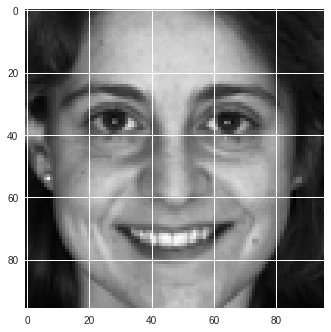

In [47]:
import matplotlib.pyplot as plt
plt.imshow(imgs[10],cmap = 'gray')

In [0]:
import matplotlib.pyplot as plt
def plotPoints(img,points):
  plt.imshow(img,cmap = 'gray')
  for i in range(0,30,2):
    plt.scatter((points[i]+0.5) * 96,(points[i+1]+0.5) * 96,color = 'red')

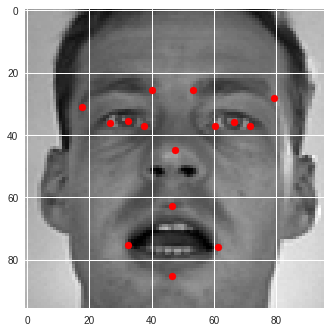

In [52]:
plotPoints(imgs[1],points[1])

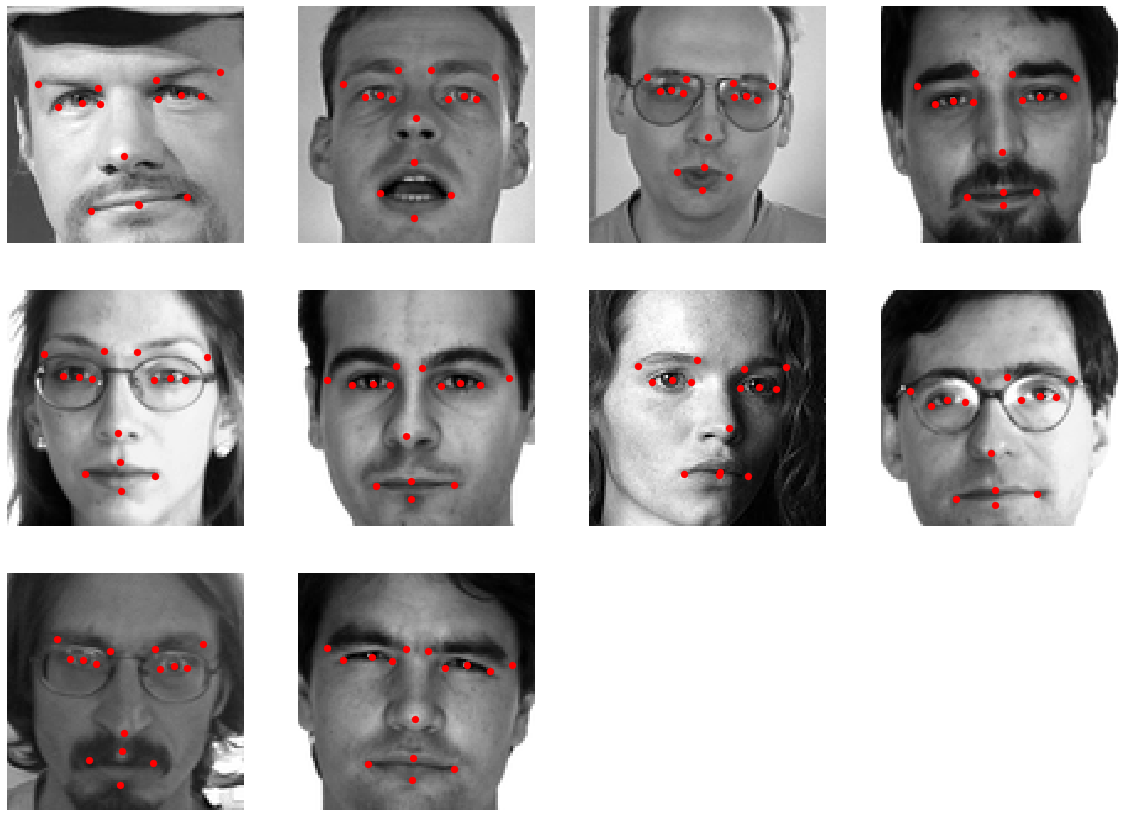

In [55]:
fig = plt.figure(figsize = (20,20))
for i in range(0,10):
  fig.add_subplot(4,4,i+1,xticks = [] , yticks=[])
  plotPoints(imgs[i],points[i])

In [60]:
imgs.shape

(2140, 96, 96)

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

In [0]:
#data augmentation
import numpy as np

def dataAugmentation(img,points):
  rows,cols = img.shape
  new_img = np.copy(img)
  for i in range(96):
    for j in range(48):
      temp = img[i][j]
      new_img[i][j] = img[i][cols-j-1]
      new_img[i][cols-j-1] = temp
  
  new_points = np.copy(points)
  for i in range(0,30,2):
    new_points[i] = -points[i]
  
  return new_img,new_points

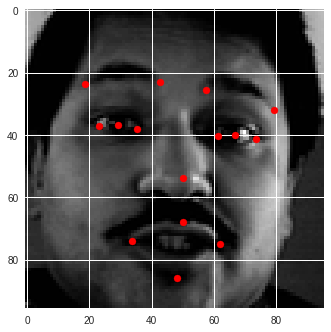

In [74]:
flip_img,flip_points = dataAugmentation(imgs[10],points[10])
plotPoints(flip_img,flip_points)

In [86]:
from tqdm import tqdm

augment_img_train = []
augment_points_train = []

for i in tqdm(range(0,imgs_train.shape[0])):
  aug_img,aug_point = dataAugmentation(imgs_train[i],points_train[i])
  
  augment_img_train.append(imgs_train[i])
  augment_points_train.append(points_train[i])
  
  augment_img_train.append(aug_img)
  augment_points_train.append(aug_point)

# converts to numpy
augment_img_train = np.array(augment_img_train)
augment_points_train = np.array(augment_points_train)
  
print (augment_img_train.shape)
print (augment_img_train.shape)

100%|██████████| 1926/1926 [00:11<00:00, 170.93it/s]

(3852, 96, 96)
(3852, 96, 96)


In [87]:
augment_img_train.shape

(3852, 96, 96)

In [88]:
augment_points_train.shape

(3852, 30)

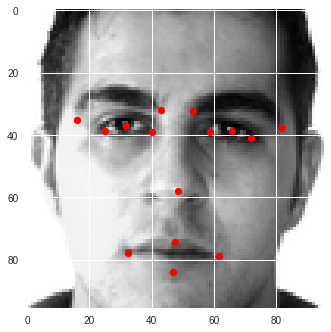

In [76]:
id = 200
plotPoints(augment_img_train[id+1], augment_points_train[id+1])

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D, Flatten , Dense , Dropout
from keras.callbacks import History
from keras.optimizers import Adam

In [0]:
augment_img_train = augment_img_train.reshape(augment_img_train.shape[0],96,96,1)
imgs_val = imgs_val.reshape(imgs_val.shape[0],96,96,1)

In [101]:
hist = History()

model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size = 3 , activation = 'relu' , input_shape = (96,96,1)))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 32 , kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 64 , kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 128 , kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(30))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         73856     
__________

In [0]:
model.compile(loss = 'mean_squared_error' , optimizer = 'adam' , metrics = ['accuracy'])

In [103]:
hist = model.fit(augment_img_train , augment_points_train , validation_split=0.1 , batch_size = 64 , shuffle = True , epochs = 150 , verbose = 1)

Train on 3466 samples, validate on 386 samples
Epoch 1/150
3466/3466 [==============================] - 2s 691us/step - loss: 0.0209 - acc: 0.5837 - val_loss: 0.0188 - val_acc: 0.6865
Epoch 2/150
3466/3466 [==============================] - 2s 491us/step - loss: 0.0190 - acc: 0.6763 - val_loss: 0.0186 - val_acc: 0.6865
Epoch 3/150
3466/3466 [==============================] - 2s 496us/step - loss: 0.0176 - acc: 0.6760 - val_loss: 0.0185 - val_acc: 0.6865
Epoch 4/150
3466/3466 [==============================] - 2s 499us/step - loss: 0.0144 - acc: 0.6737 - val_loss: 0.0112 - val_acc: 0.6839
Epoch 5/150
3466/3466 [==============================] - 2s 495us/step - loss: 0.0108 - acc: 0.6480 - val_loss: 0.0100 - val_acc: 0.6528
Epoch 6/150
3466/3466 [==============================] - 2s 495us/step - loss: 0.0088 - acc: 0.6339 - val_loss: 0.0081 - val_acc: 0.6192
Epoch 7/150
3466/3466 [==============================] - 2s 497us/step - loss: 0.0072 - acc: 0.6347 - val_loss: 0.0082 - val_acc: 0

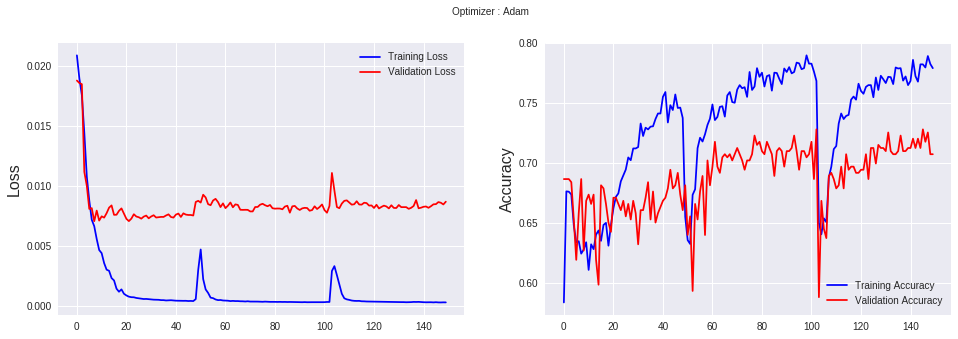

In [104]:
# loss plot 
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [105]:
imgs_val.shape

(214, 96, 96)

In [107]:
fig = plt.figure(figsize=(15,15))
points_test = model.predict(imgs_val.reshape(imgs_val.shape[0],96,96,1))

In [96]:
points_test

array([[-1.5356262e-01, -9.0648539e-02,  1.3544297e-01, ...,
         3.5224965e-01,  1.3146175e-02,  4.0323874e-01],
       [-1.8552892e-01, -1.1568438e-01,  1.8391049e-01, ...,
         2.6529095e-01,  3.4626562e-02,  3.5355467e-01],
       [ 1.5751439e-01, -7.4109182e-02, -1.5592347e-01, ...,
         3.3118799e-01, -9.8337159e-03,  4.0012544e-01],
       ...,
       [ 1.8496263e-01, -9.6118413e-02, -1.8808563e-01, ...,
         2.2364782e-01, -4.3309890e-03,  4.0978754e-01],
       [-3.8452446e-05, -1.5052250e-01, -8.5765691e-03, ...,
         3.0659106e-01,  6.6965725e-03,  3.8158831e-01],
       [ 1.8913695e-01, -9.7495183e-02, -1.9797529e-01, ...,
         2.6718825e-01,  8.4739621e-04,  4.1086638e-01]], dtype=float32)

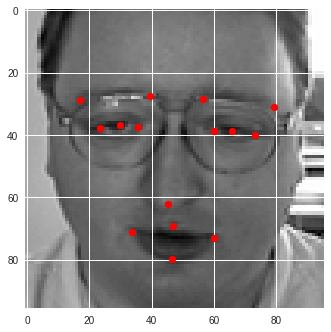

In [108]:
plotPoints(imgs_val[100] , points_test[100])